Creating an RL agent


In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class FrozenlakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Q-Learning agent.

        Args:
            env: The training environment
            learning_rate: How quickly to update Q-values (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        self.env = env

        # Q-table: maps (state, action) to expected reward
        # defaultdict automatically creates entries with zeros for new states
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """Choose an action using epsilon-greedy strategy.

        Returns:
            actions from the action space
        """
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Update Q-value based on experience.

        This is the heart of Q-learning: learn from (state, action, reward, next_state)
        """
        # What's the best we could do from the next state?
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        # What should the Q-value be? (Bellman equation)
        target = reward + self.discount_factor * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[obs][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Initializing the environment and the agent  

Training loop

In [2]:
import os
import shutil
import gymnasium as gym
from tqdm import tqdm


# --- Setup ---
video_folder = "frozenlake-training-videos"

# Clean video folder
if os.path.exists(video_folder):
    shutil.rmtree(video_folder)
os.makedirs(video_folder)

# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 10_0000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration


# Create environment ONCE, with both wrappers
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode="rgb_array")

# Record every 1000th episode
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    name_prefix="train",
    episode_trigger=lambda ep: ep % 10000 == 0
)

# Track rewards and lengths
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Initialize agent
agent = FrozenlakeAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# --- Training Loop ---
for episode in tqdm(range(1, n_episodes + 1)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Track training error inside agent
        agent.update(obs, action, reward, terminated, next_obs)

        obs = next_obs
        done = terminated or truncated

    agent.decay_epsilon()

# Close environment to flush videos
env.close()


/home/mostach/miniconda3/envs/py310env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/mostach/projects/rl/frozen-lake-slippery-same-map-QLearning/frozenlake-training-videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 100000/100000 [02:03<00:00, 811.79it/s]


Plotting stats of the training episodes


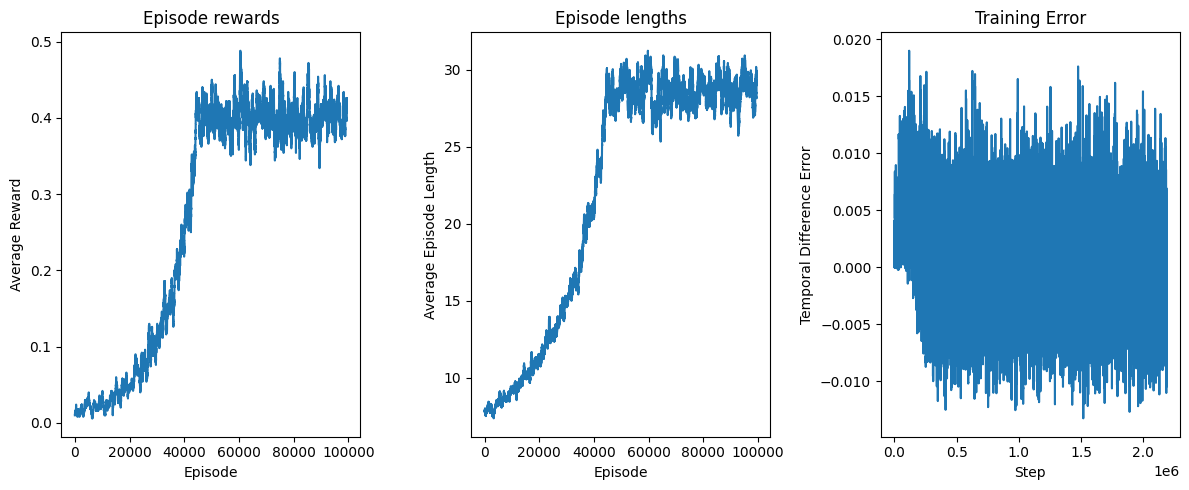

In [3]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

Evaluation

In [4]:
# Test the trained agent
def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    # Temporarily disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_rewards.append(episode_reward)

    # Restore original epsilon
    agent.epsilon = old_epsilon

    win_rate = np.mean(np.array(total_rewards) > 0)
    average_reward = np.mean(total_rewards)

    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")

# Test your agent
test_agent(agent, env)

Test Results over 1000 episodes:
Win Rate: 75.1%
Average Reward: 0.751
Standard Deviation: 0.432


Recoding episodes for visual interpertation

In [5]:
import os
import shutil
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import numpy as np

# ✅ Set number of episodes to record
num_eval_episodes = 4

# ✅ Define video folder
video_folder = "frozenlake-agent"

# ✅ Delete folder if it exists, then create it
if os.path.exists(video_folder):
    shutil.rmtree(video_folder)
os.makedirs(video_folder)

# ✅ Create the base environment
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode="rgb_array")

# ✅ Wrap the environment to record videos
env = RecordVideo(
    env,
    video_folder=video_folder,          # Folder to save videos
    name_prefix="eval",                 # Prefix for video filenames
    episode_trigger=lambda x: True      # Record every episode
)

# ✅ Add wrapper to track episode stats
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

# ✅ Disable exploration for evaluation
old_epsilon = agent.epsilon
agent.epsilon = 0.0  # Pure exploitation

print(f"Starting evaluation for {num_eval_episodes} episodes...")
print(f"Videos will be saved to: {video_folder}/")

# ✅ Run evaluation episodes
for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    episode_reward = 0
    step_count = 0
    done = False

    while not done:
        action = agent.get_action(obs)  # Use trained agent's policy
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        step_count += 1
        done = terminated or truncated

    print(f"Episode {episode_num + 1}: {step_count} steps, reward = {episode_reward}")

# ✅ Close environment to flush video recordings
env.close()

# ✅ Restore original epsilon
agent.epsilon = old_epsilon

# ✅ Print summary statistics
print(f'\nEvaluation Summary:')
print(f'Episode durations: {list(env.time_queue)}')
print(f'Episode rewards: {list(env.return_queue)}')
print(f'Episode lengths: {list(env.length_queue)}')

# ✅ Calculate useful metrics
avg_reward = np.mean(env.return_queue)
std_reward = np.std(env.return_queue)
avg_length = np.mean(env.length_queue)
success_rate = sum(1 for r in env.return_queue if r > 0) / len(env.return_queue)

print(f'\nAverage reward: {avg_reward:.2f} ± {std_reward:.2f}')
print(f'Average episode length: {avg_length:.1f} steps')
print(f'Success rate: {success_rate:.1%}')


Starting evaluation for 4 episodes...
Videos will be saved to: frozenlake-agent/
Episode 1: 13 steps, reward = 1.0


/home/mostach/miniconda3/envs/py310env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/mostach/projects/rl/frozen-lake-slippery-same-map-QLearning/frozenlake-agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 2: 9 steps, reward = 0.0
Episode 3: 35 steps, reward = 1.0
Episode 4: 30 steps, reward = 1.0

Evaluation Summary:
Episode durations: [0.036698, 0.012156, 0.046563, 0.043801]
Episode rewards: [1.0, 0.0, 1.0, 1.0]
Episode lengths: [13, 9, 35, 30]

Average reward: 0.75 ± 0.43
Average episode length: 21.8 steps
Success rate: 75.0%
